In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

NSW_weather_data_12mth.csv
(28995, 11)
                         station_name        date ev_transpiration rain  \
0  ALBION PARK (SHELLHARBOUR AIRPORT)  01/02/2023              5.3  0.0   
1  ALBION PARK (SHELLHARBOUR AIRPORT)  02/02/2023              5.8  0.0   
2  ALBION PARK (SHELLHARBOUR AIRPORT)  03/02/2023              7.7  0.0   

  pan_ev max_temp min_temp max_humid min_humid  wind  solar  
0            27.3     18.7      85.0      58.0  2.99  26.60  
1            29.2     18.4      99.0      49.0  3.99  27.15  
2            27.5     17.8      75.0      26.0  6.55  28.18  
              solar
count  28995.000000
mean      17.439539
std        7.195312
min        1.190000
25%       11.660000
50%       16.330000
75%       23.420000
max       32.170000


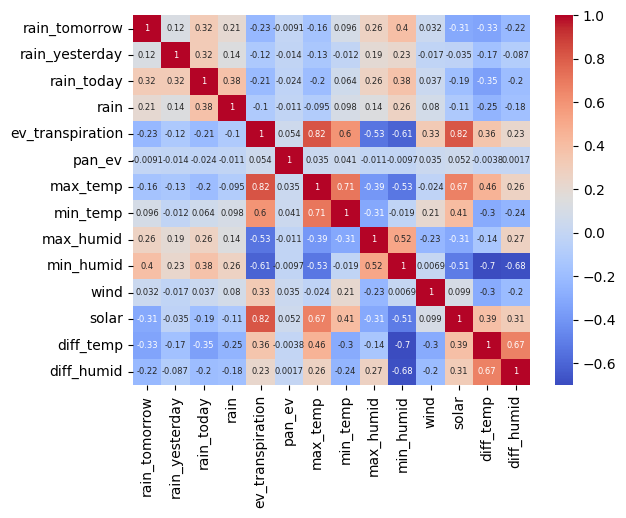

<Figure size 1400x1400 with 0 Axes>

(23196, 8) (5799, 8) (23196,) (5799,)
The classification accuracy of Logistic Regression model is 77.08%


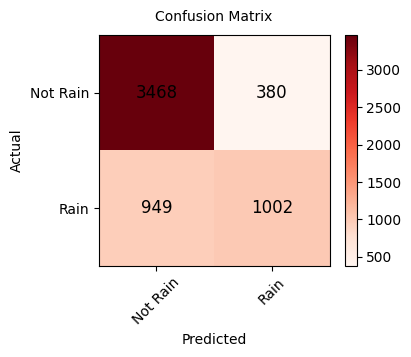

Logistic Regression Classification Report
              precision    recall  f1-score   support

    Not Rain       0.79      0.90      0.84      3848
        Rain       0.73      0.51      0.60      1951

    accuracy                           0.77      5799
   macro avg       0.76      0.71      0.72      5799
weighted avg       0.76      0.77      0.76      5799



In [2]:
# Read the file
filename = 'NSW_weather_data_12mth.csv'
observe = pd.read_csv(filename, sep =',',index_col = 0)

# Adjust column types
int_col = ['ev_transpiration','rain','pan_ev','max_temp','min_temp','max_humid','min_humid','wind','solar']
for col in int_col:
    observe[col] = pd.to_numeric(observe[col], errors='coerce')
    observe[col] = observe[col].astype(float)

observe['date'] = pd.to_datetime(observe['date'], format='%d/%m/%Y')

# Sort values
observe = observe.sort_values(['station_name','date'])

## fill nan value with mean
for col in int_col:
    observe[col] = observe[col].fillna(observe[col].mean())

In [ ]:
# Add rain today, rain yesterday column
observe['rain_today'] = np.where(observe['rain'] > 0, 1, 0)
observe['rain_yesterday'] = (observe['rain_today'].shift(1) == 1).astype(int).fillna(0)
observe['rain_tomorrow'] = (observe['rain_today'].shift(-1) == 1).astype(int).fillna(0)

# Add difference temp, humid
observe['diff_temp'] = observe['max_temp'] - observe['min_temp']
observe['diff_humid'] = observe['max_humid'] - observe['min_humid']

# Get month number from datetime
observe['month_number'] = observe['date'].dt.month

# Normalize columns
norm_col = ['ev_transpiration','rain','pan_ev','max_temp','min_temp','max_humid','min_humid','wind','solar', 'diff_temp', 'diff_humid']
scaler = MinMaxScaler()
data_normalize = observe[norm_col]
observer_normalize = scaler.fit_transform(data_normalize)
observe_normalize = pd.DataFrame(observer_normalize, columns=norm_col)
observe[norm_col] = observe_normalize

In [ ]:
# Correlation heatmap
corr_col =  ['rain_tomorrow','rain_yesterday', 'rain_today', 'rain', 'ev_transpiration','pan_ev','max_temp','min_temp','max_humid','min_humid','wind','solar', 'diff_temp', 'diff_humid']
sns.heatmap(observe[corr_col].corr(), annot=True, cmap="coolwarm", annot_kws={"size": 6})
plt.figure(figsize=(14, 14))
plt.show()

In [ ]:
## prepare data set, then split train , test set
### original_col
# x_col = ['ev_transpiration','rain','pan_ev','max_temp','min_temp','max_humid','min_humid','wind','solar','rain_yesterday', 'rain_today'
#          , 'diff_temp', 'diff_humid','month_number']
x_col = ['ev_transpiration','max_temp','min_temp','max_humid','min_humid','wind','solar','month_number']

X = observe[x_col]
y = observe['rain_tomorrow']

X_train, X_val, y_train, y_val = train_test_split(X, y , test_size = 0.2, random_state = 10)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

In [ ]:
##  Logistic Regression
## model
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

## predict
# log_reg_model.predict(X_val)

## model score, model accuracy
log_reg_model_score = log_reg_model.score(X_val, y_val)
log_reg_model_accuracy = round(log_reg_model_score * 100, 2)

print("The classification accuracy of Logistic Regression model is " + str(log_reg_model_accuracy) + "%")

## confusion matrix
y_pred = log_reg_model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

## plot heatmap
plt.figure(figsize=(4, 3))
plt.imshow(cm, cmap='Reds')

# Add text annotations
for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j, i, str(cm[i][j]), ha='center', va='center', color='black', fontsize=12)

# Set labels and title
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.title('Confusion Matrix', fontsize=10, pad=10)

# Set class labels
class_labels = ['Not Rain', 'Rain']
plt.xticks(range(len(class_labels)), class_labels, rotation=45)
plt.yticks(range(len(class_labels)), class_labels, rotation=0)

plt.colorbar()
plt.show()

## classification report
print('Logistic Regression Classification Report')
print('=========================================')

print(classification_report(y_val, y_pred, target_names = class_labels))